<h1>Predicting Rain in Australia</h1>

<h2>Table of Contents</h2>
<ul>
  <li><a href="#section1">1. Project Description</a></li>
  <li><a href="#section2">2. Data Understanding</a></li>
  <li><a href="#section3">3. Exploratory Data Analysis (EDA)</a></li>
  <li><a href="#section4">4. Data Preprocessing</a></li>
  <li><a href="#section5">5. Model Selection</a></li>
  <li><a href="#section6">6. Model Training & Evaluation</a></li>
  <li><a href="#section7">7. Hyperparameter Tuning</a></li>
  <li><a href="#section8">8. Final Evaluation & Model Saving</a></li>
  <li><a href="#section9">9. Feature Importance / Explainability</a></li>
  <li><a href="#section10">10. Conclusions & Next Steps</a></li>
</ul>

<a id='section1'></a>
## 1. Project Description
- Short project description
- Dataset origin
- Objective


<a id='section2'></a>
## 2. Data Understanding

### 2.1 Loading Data and imports

In [1]:
# CORE LIBRARIES
import numpy as np
import pandas as pd

# DATA VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns

# DATA PREPROCESSING
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder
)
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# MACHINE LEARNING MODELS
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from ogboost import GradientBoostingOrdinal  # ordinal classification model
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV

#SPLITTING DATA SETS INTO TRAINING AND VALIDATION SETS
from sklearn.model_selection import train_test_split

# MODEL EVALUATION METRICS
from sklearn.metrics import (
    accuracy_score,
    cohen_kappa_score,
    mean_absolute_error,
    make_scorer
)

In [2]:
df = pd.read_csv('weatherAUS.csv')
print(df.head())

         Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7    

In [3]:
# Number of observation and variables
df.shape

(145460, 23)

In [4]:
# Checking if there are duplicated rows
df.duplicated().sum()

np.int64(0)

In [5]:
# Shows the features --- What is the target variable?
print('Features: ', [col for col in df.columns if col != 'RainTomorrow'])

Features:  ['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday']


In [6]:
# Checks the data types of the variables
df.dtypes
#Aissata: the data types seem to be correct for each feature, so we will use them as they are to define column types.

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

In [7]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

## 2.2 Definition of General Variables
Defining General Variables helps...

Aissata: removed ordinal/nominal features because all categorical features seem to be nominal, so no need to distinguish. Also updated the code logic for simplicity.

In [9]:
# what is type is Date, Shunshine, Evaporation?
# are the others correct?

target = 'RainTomorrow'
features = [col for col in df.columns if col != target]

numerical_features = [col for col in df.columns if col in features and df[col].dtype == 'float64']

categorical_features = [col for col in df.columns if col in features and col not in numerical_features]

print('Target variable: ', target)
print('All features: ', features)
print('Numerical features: ', numerical_features)
print('Categorical features: ', categorical_features)

Target variable:  RainTomorrow
All features:  ['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday']
Numerical features:  ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
Categorical features:  ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']


In [10]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


<a id='section3'></a>
## 3. Exploratory Data Analysis (EDA)

TODO
- Check target distribution
- Univariate & bivariate analysis
- Correlation heatmap
- Outlier inspection

We start with Explorator Data Analysis to explore distribution, patterns and relationships between the variables.

In [11]:
df_eda = df.copy()


### 3.1 Minimal Data Cleaning for Exploratory Data Analysis

> Is this always the same? And can I do it like in your hospital project?
- Missing data
- Categorical variables / features
- Inconsistent Data Types
- Detection and outliers



#### Missing Values

In [12]:
df_eda.isna().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

Aissata: We have a lot of missing values. We will have to really justify what we do with these.

### 3.2 Univariate Analysis

- Check each variable for their data type and target distribution


<a id='section4'></a>
## 4. Data Preprocessing
- Handle missing values
- Encode categorical variables
- Scale numerical variables
- Train-test split


Aissata: Detecting high cardinality in categorical features here (useful in order to optimize the training of our models).

In [13]:
# Detect nominal features with high-cardinality
HIGH_CARDINALITY_THRESHOLD = 10
high_card_features = [
    (col, df[col].nunique())
    for col in categorical_features
    if df[col].nunique() > HIGH_CARDINALITY_THRESHOLD
]

# Separate low/high-cardinality nominal columns
low_card_features = [col for col in categorical_features if col not in [c for c, _ in high_card_features]]
high_card_features_names = [col for col, _ in high_card_features]

print("High-cardinality features:", high_card_features_names)
print("Low-cardinality features: ",low_card_features)

High-cardinality features: ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
Low-cardinality features:  ['RainToday']


<a id="split-data"></a>
#### 4.1 Split Data into Test and Validation Sets

Aissata: Checking target distribution to see if it is balanced or not. Will determine if we stratify or not when splitting into test and training sets.

Class distribution:
RainTomorrow
No     0.775819
Yes    0.224181
Name: proportion, dtype: float64


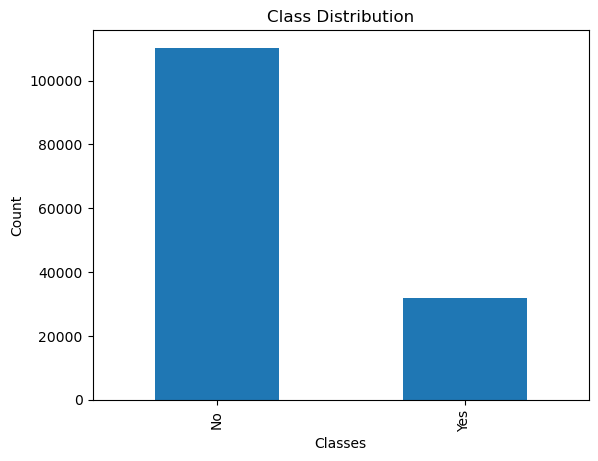

In [15]:
print("Class distribution:")
print(df[target].value_counts(normalize=True))  # relative frequencies

# Plot for better visualization
df[target].value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()


Since Target is imbalanced, we will apply stratification when splitting the data.

In [19]:
df = df.dropna(subset=[target])   # drop rows with missing target
# Define features matrix X and target vector y
y = df[target] 
X = df.drop(columns=[target])

# First split into (train + val) and test sets - 80% (train + val), 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # or use stratify=y because target is categorical/imbalanced
)

# Then split again (train + val) into train and validation sets - 75% train, 25% val of remaining 80%
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.25,  # 0.25 * 0.8 = 0.2 of original data for validation
    random_state=42,
    stratify=y_train_val
)

print(f"Train size: {X_train.shape[0]}")
print(f"Validation size: {X_val.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

Train size: 85315
Validation size: 28439
Test size: 28439


<a id="target-preparation"></a>
### 4.2 Target Data Preparation

We must encode the target. As it is a low cardinality variables (only 2 possible option), we will one hot encode it.

<a id="features-preprocessing"></a>
### 4.3 Features Preprocessing

<a id='section5'></a>
## 5. Model Selection
- Try several baseline models
- Logistic Regression, Random Forest, SVM, etc.


<a id='section6'></a>
## 6. Model Training & Evaluation

<a id='section7'></a>
## 7. Hyperparameter Tuning
- GridSearchCV / RandomizedSearchCV


<a id='section8'></a>
## 8. Final Evaluation & Model Saving

<a id='section9'></a>
## 9. Feature Importance / Explainability


<a id='section10'></a>
## 10. Conclusions & Next Steps